In [2]:
library(dplyr)
library(rio) #great for exporting, importing
library (stringr)
library(cowplot)
library(tidyr)
library(ggpubr)

library(readxl)
library(patchwork)
library(RColorBrewer)
library(viridis)
library(ggvenn)
library(gridExtra)

In [3]:
CHC <- import(
       '../01_Data_normalization/Results/CHC_diel_leaf_avsd_expressed.csv', sep = ',', header =TRUE)

In [5]:
CND <- import(
       '../01_Data_normalization/Results/CND_diel_leaf_avsd_expressed.csv', sep = ',', header =TRUE)

In [6]:
ATL <- import(
       '../01_Data_normalization/Results/ATL_diel_leaf_avsd_expressed.csv', sep = ',', header =TRUE)

In [4]:
CHC[1:2,]

,geneID,ZT,Tissue,Condition,mean_expression,std,target_id,Genotype
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,Solch.M6.01G000010.3,0,Leaf,LD,6.814213,0.2254201,Solch.M6.01G000010,CHC
2,Solch.M6.01G000010.3,0,Leaf,SD,6.860834,0.2677401,Solch.M6.01G000010,CHC


In [7]:
nrow(ATL)
SDLD <- rbind(CHC, CND, ATL)
nrow(SDLD)

[1] 2723409

[1] 4368959

# Add syntelog information to expression table

In [8]:
#### Get syntelogs ####
#::::::::::::::::::::::::::

SYN<- import(file = '~/Dropbox/Potato/RNA-seq_2/RNAseq_analysis/Data/GeneLists/Syntelogs_Ann/syntelogs_atl_good.csv', sep =',', header = TRUE, fill = TRUE )

In [9]:
# Check file 
#::::::::::::;;
SYN[1:2,]

,V1,Syntelog,geneID,Species
,<int>,<chr>,<chr>,<chr>
1,0,Synt_0,Soltu.DM.01G000010.5,
2,1,Synt_0,Solca.01G000010.5,


In [11]:
# Select only the necessary columns
#:::::::::::::::::::
SYN <- SYN %>% select(Syntelog, geneID)

### Add syntelog information 
# Make a target_id column 

SYN <- SYN %>% mutate(target_id = geneID)

#Remove transcript information from SYN$target_id

## REMOVE transcript version for versions from .1-.99 

SYN$target_id<-lapply(SYN$target_id,
                             function (i){if (str_sub(i,-2,-2) == ".")
                                             { i<- str_sub(i, end = -3)} # i.e. the last character will be -3 position
                                          else if ((str_sub(i,-3,-3) == "."))
                                               { i<- str_sub(i, end = -4)} # i.e. the last character will be -4 position
                                        else {i<-i}
                                          
                                        })


SYN$target_id <- as.character(SYN$target_id)
SYN[1:2,]

,Syntelog,geneID,target_id
,<chr>,<chr>,<chr>
1,Synt_0,Soltu.DM.01G000010.5,Soltu.DM.01G000010
2,Synt_0,Solca.01G000010.5,Solca.01G000010


In [12]:
# Add Syntelog information
#::::::::::::::::::::::::::::::::
SDLDs <- SDLD %>% left_join(SYN %>% select(target_id, Syntelog) , by = 'target_id')
SDLDs[1:2,]

,geneID,ZT,Tissue,Condition,mean_expression,std,target_id,Genotype,Syntelog
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,Solch.M6.01G000010.3,0,Leaf,LD,6.814213,0.2254201,Solch.M6.01G000010,CHC,NA
2,Solch.M6.01G000010.3,0,Leaf,SD,6.860834,0.2677401,Solch.M6.01G000010,CHC,NA


In [31]:
colnames(SDLDs[8])
SDLDs<- rename(SDLDs, Genome = Genotype)
colnames(SDLDs[8])

[1] "Genotype"

[1] "Genome"

In [32]:


SDLDsg <- SDLDs %>% mutate(Genome = case_when(Genome == 'ATL' & str_detect(target_id, '_1G') ~ 'ATL_H1',
                                             Genome == 'ATL' & str_detect(target_id, '_2G') ~ 'ATL_H2',
                                             Genome == 'ATL' & str_detect(target_id, '_3G') ~ 'ATL_H3',
                                             Genome == 'ATL' &  str_detect(target_id, '_4G') ~ 'ATL_H4',
                                             Genome == 'ATL' &  str_detect(target_id, '_0G') ~ 'ATL_0G',
                                             Genome == 'ATL' & str_detect(target_id, 'v3.S') ~ 'ATL_S0',
                                               .default = Genome))

In [33]:
SDLDsg[1:2,]

,geneID,ZT,Tissue,Condition,mean_expression,std,target_id,Genome,Syntelog
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,Solch.M6.01G000010.3,0,Leaf,LD,6.814213,0.2254201,Solch.M6.01G000010,CHC,NA
2,Solch.M6.01G000010.3,0,Leaf,SD,6.860834,0.2677401,Solch.M6.01G000010,CHC,NA


# Defining plot functions

In [34]:
#Defining ribbon LD plot 
LD_ribbon_plot_multiple <- function(df,columns) {

plot_clock <- df %>% 
  ggplot(.,aes(x=ZT,y=mean_expression,col=Genome))+ # this means that all colors below are determined by Genome
    geom_rect(aes(xmin= 16,
                  xmax = 24,
                  ymin = -Inf,
                  ymax = Inf), 
                 fill = 'grey', alpha = 0.25, color = NA) +
  geom_line(aes(x=ZT,y=mean_expression, col = Genome, group = Genome))+ #group will separate different genes from the same Abbreviation
  geom_ribbon(aes(ymin=mean_expression-std,ymax=mean_expression+std, fill = Genome, group = Genome),alpha=0.2, linetype = 0)+
  facet_wrap(~Syntelog, scales = 'free_y', ncol = columns)+
  theme(strip.background = element_blank(), #removes legend box/grey
        panel.grid =element_blank(),
       panel.background = element_rect(fill = FALSE, colour = "grey50"),
       panel.ontop = TRUE)+
       #legend.position="bottom")+
  scale_y_continuous()+
  scale_x_continuous(breaks=c(0,16,24))+
  labs(y="rlog", x="ZT (h)")+
     scale_color_manual(values = c('CHC' = '#9c3b40',
                                   'CND'='#3c1478',
                                    'ATL_0G'='#8fafbc',
                                   'ATL_H1'='#8fafbc',
                                   'ATL_H2'='#8fafbc',
                                   'ATL_H3'='#8fafbc',
                                  'ATL_H4'='#8fafbc'))+
    
   scale_fill_manual(values = alpha(c('CHC' = '#9c3b40',
                                   'CND'='#3c1478',
                                    'ATL_0G'='#8fafbc',
                                   'ATL_H1'='#8fafbc',
                                   'ATL_H2'='#8fafbc',
                                   'ATL_H3'='#8fafbc',
                                  'ATL_H4'='#8fafbc'), 0.2))   
    
  
}


In [35]:
#Defining ribbon SD plot 
SD_ribbon_plot_multiple <- function(df,columns) {

plot_clock <- df %>% 
  ggplot(.,aes(x=ZT,y=mean_expression,col=Genome))+ # this means that all colors below are determined by Genome
    geom_rect(aes(xmin= 12,
                  xmax = 24,
                  ymin = -Inf,
                  ymax = Inf), 
                 fill = 'grey', alpha = 0.25, color = NA) +
  geom_line(aes(x=ZT,y=mean_expression, col = Genome, group = Genome))+ #group will separate different genes from the same Abbreviation
  geom_ribbon(aes(ymin=mean_expression-std,ymax=mean_expression+std, fill = Genome, group = Genome),alpha=0.2, linetype = 0)+
  facet_wrap(~Syntelog, scales = 'free_y', ncol = columns)+
  theme(strip.background = element_blank(), #removes legend box/grey
        panel.grid =element_blank(),
       panel.background = element_rect(fill = FALSE, colour = "grey50"),
       panel.ontop = TRUE)+
       #legend.position="bottom")+
  scale_y_continuous()+
  scale_x_continuous(breaks=c(0,12,24))+
  labs(y="rlog", x="ZT (h)")+
     scale_color_manual(values = c('CHC' = '#9c3b40',
                                   'CND'='#3c1478',
                                    'ATL_0G'='#8fafbc',
                                   'ATL_H1'='#8fafbc',
                                   'ATL_H2'='#8fafbc',
                                   'ATL_H3'='#8fafbc',
                                  'ATL_H4'='#8fafbc'))+
    
   scale_fill_manual(values = alpha(c('CHC' = '#9c3b40',
                                   'CND'='#3c1478',
                                    'ATL_0G'='#8fafbc',
                                   'ATL_H1'='#8fafbc',
                                   'ATL_H2'='#8fafbc',
                                   'ATL_H3'='#8fafbc',
                                  'ATL_H4'='#8fafbc'), 0.2))   
    
  
}

# Ann potential TF regulators
Here is the list of the 6 synts orthologous to the Arabidopsis TFs whose motifs were both enriched in Module 6 (and no unshifted modules) and were found in the DEL1 promoter.


In [24]:
DEL1_reg <-c('Synt_26718', 'Synt_28678', 'Synt_11370', 'Synt_26172','Synt_20252')


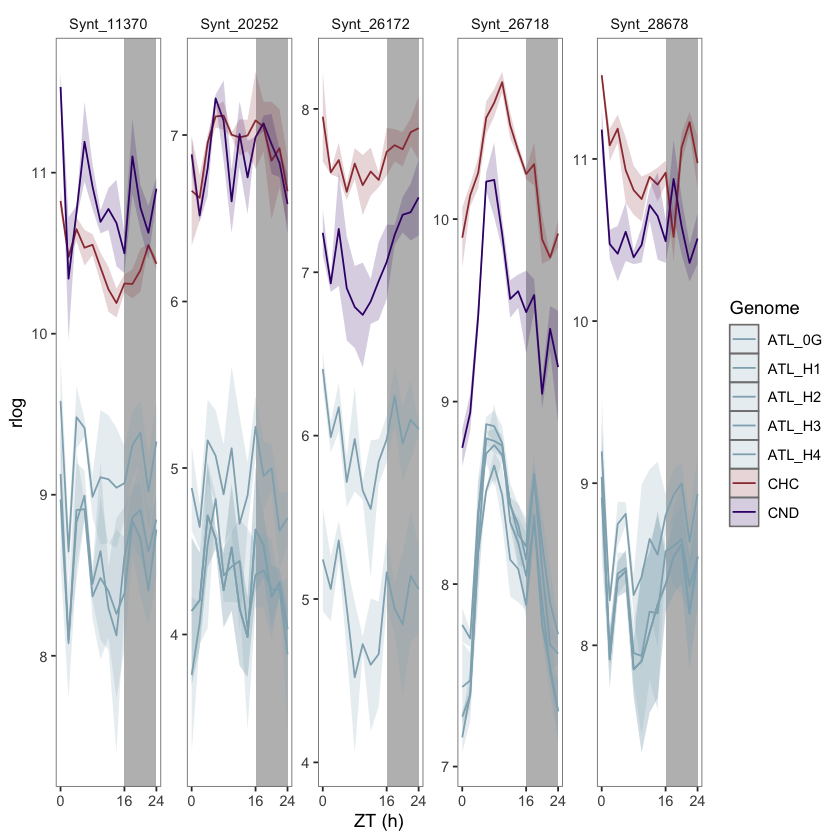

In [41]:
DEL1_reg_LDplot <- SDLDsg %>% filter (Condition == 'LD', Syntelog %in%DEL1_reg ) %>% 
LD_ribbon_plot_multiple(.,5)

DEL1_reg_LDplot

In [40]:
SDLDsg %>% select(geneID, target_id, Syntelog) %>% filter ( Syntelog %in%DEL1_reg ) %>% unique()

,geneID,target_id,Syntelog
,<chr>,<chr>,<chr>
1,Solch.M6.04G020870.1,Solch.M6.04G020870,Synt_11370
27,Solch.M6.08G009100.1,Solch.M6.08G009100,Synt_20252
53,Solch.M6.11G000080.1,Solch.M6.11G000080,Synt_26172
79,Solch.M6.11G008730.1,Solch.M6.11G008730,Synt_26718
105,Solch.M6.12G008230.2,Solch.M6.12G008230,Synt_28678
131,Solca.04G023280.1,Solca.04G023280,Synt_11370
157,Solca.08G012220.1,Solca.08G012220,Synt_20252
183,Solca.11G000110.1,Solca.11G000110,Synt_26172
209,Solca.11G008650.1,Solca.11G008650,Synt_26718


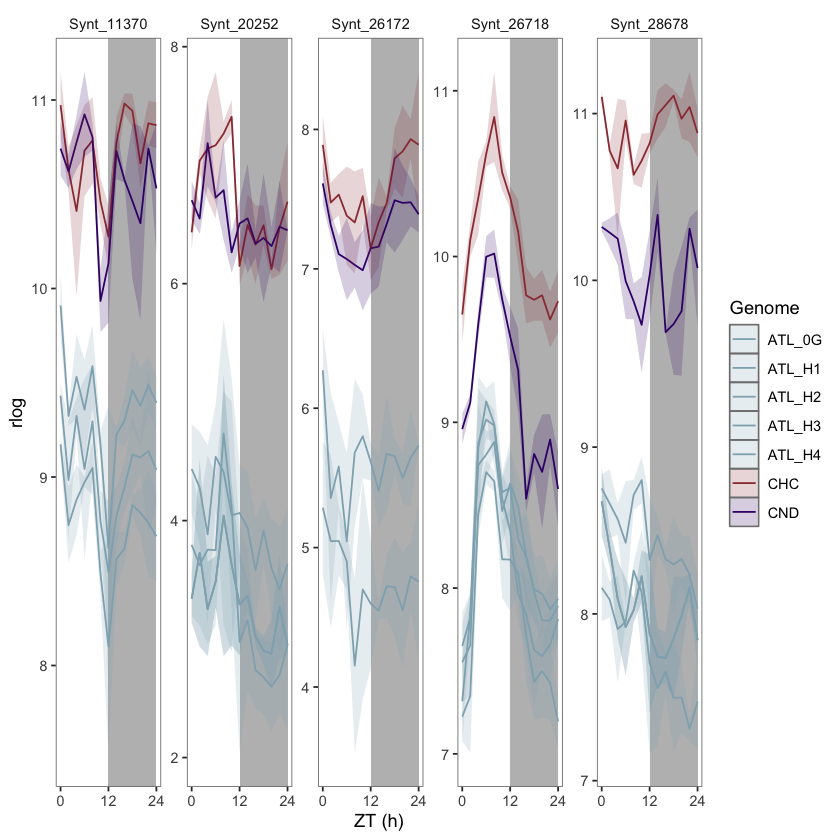

In [42]:
DEL1_reg_SDplot <- SDLDsg %>% filter (Condition == 'SD', Syntelog %in%DEL1_reg ) %>% 
SD_ribbon_plot_multiple(.,5)

DEL1_reg_SDplot

In [43]:
DEL1_reg_SDplot %>% save_plot(file="./Results/DEL1_reg_SDplot.pdf", base_height = 2.25 , base_asp = 4)

